In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib as mpl

import readdy_learn.analyze.analyze as ana
import readdy_learn.analyze.basis as basis

import pynumtools.kmc as kmc

#mpl.rcParams['figure.figsize'] = (13, 13)
import matplotlib.pyplot as plt

/srv/public/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def plot_overview(plot_functions, n_rows=2, n_cols=2, size_factor=1.):
    plt.figure(1, figsize=(5*n_cols*size_factor,3.5*n_rows*size_factor))
    n_plots = n_rows * n_cols
    idx = 1
    for pf in plot_functions:
        if idx > n_plots:
            break
        plt.subplot(n_rows, n_cols, idx)
        #plt.xscale("log")
        pf()
        plt.legend(loc="best")
        idx += 1

    #plt.subplots_adjust(top=0.88, bottom=0.08, left=0.10, right=0.95, hspace=0.4, wspace=0.35)
    plt.tight_layout(pad=0.6, w_pad=2.0, h_pad=2.0)

## regulation (negative/repression) network of proteins A, B and C
There are 9 possible edges in the regulation network described by rates $k_{ij}$, where $i, j\in \{A,B,C\}$ 

In [3]:
# species DA  MA  A  DB  MB  B  DC  MC  C
# ids     0   1   2  3   4   5  6   7   8
n_species = 9
species_names = ["DA", "MA", "A", "DB", "MB", "B", "DC", "MC", "C"]
desired_rates = np.array([
    1.8, # DA -> DA + MA, transcription A
    2.1, # MA -> MA + A, translation A
    1.3, # MA -> 0, decay
    1.5, # A -> 0, decay
    2.2, # DB -> DB + MB, transcription B
    2.0, # MB -> MB + B, translation B
    2.0, # MB -> 0, decay
    2.5, # B -> 0, decay
    3.2, # DC -> DC + MC, transcription C
    3.0, # MC -> MC + C, translation C
    2.3, # MC -> 0, decay
    2.5, # C -> 0, decay
    # self regulation
    0., # MA + A -> A, A regulates A
    0., # MB + B -> B, B regulates B
    0., # MC + C -> C, C regulates C
    # cyclic forward
    0., # MB + A -> A, A regulates B
    0., # MC + B -> B, B regulates C
    0., # MA + C -> C, C regulates A
    # cyclic backward
    6., # MC + A -> A, A regulates C
    4., # MB + C -> C, C regulates B
    3., # MA + B -> B, B regulates A
])

initial_states = [
    [1, 0, 0, 1, 0, 0, 1, 0, 0], [1, 2, 0, 1, 0, 3, 1, 0, 0], [1, 1, 2, 1, 0, 2.5, 1, 0, 2]
]
initial_states = [np.array([arr]) for arr in initial_states]

In [4]:
ld_derivative_config = {
                'ld_derivative_atol': 1e-4,
                'ld_derivative_rtol': None,
                'ld_derivative_linalg_solver_maxit': 100000,
                'ld_derivative_alpha': 1e-1,
                'ld_derivative_solver': 'spsolve',
                'ld_derivative_linalg_solver_tol': 1e-10,
                'ld_derivative_use_preconditioner': False
            }
def set_up_system(init_state):
    sys = kmc.ReactionDiffusionSystem(diffusivity=n_species*[[[0.]]], n_species=n_species, n_boxes=1,
                                      init_state=init_state, species_names=species_names)
    # usual stuff A
    sys.add_fission("DA", "DA", "MA", np.array([desired_rates[0]])) # DA -> DA + MA transcription
    sys.add_fission("MA", "MA", "A", np.array([desired_rates[1]])) # MA -> MA + A translation
    sys.add_decay("MA", np.array([desired_rates[2]])) # MA -> 0 mRNA A decay
    sys.add_decay("A", np.array([desired_rates[3]])) # A -> 0 protein decay
    # usual stuff B
    sys.add_fission("DB", "DB", "MB", np.array([desired_rates[4]])) # DB -> DB + MB transcription
    sys.add_fission("MB", "MB", "B", np.array([desired_rates[5]])) # MB -> MB + B translation
    sys.add_decay("MB", np.array([desired_rates[6]])) # MB -> 0 mRNA B decay
    sys.add_decay("B", np.array([desired_rates[7]])) # B -> 0 protein decay
    # usual stuff C
    sys.add_fission("DC", "DC", "MC", np.array([desired_rates[8]])) # DC -> DC + MC transcription
    sys.add_fission("MC", "MC", "C", np.array([desired_rates[9]])) # MC -> MC + C translation
    sys.add_decay("MC", np.array([desired_rates[10]])) # MC -> 0 mRNA C decay
    sys.add_decay("C", np.array([desired_rates[11]])) # C -> 0 protein decay
    
    # regulation: only the real ones show up here
    # self regulation
    #sys.add_fusion("MA", "A", "A", np.array([desired_rates[12]]))  # MA + A -> A, A regulates A
    #sys.add_fusion("MB", "B", "B", np.array([desired_rates[13]]))  # MB + B -> B, B regulates B
    #sys.add_fusion("MC", "C", "C", np.array([desired_rates[14]]))  # MC + C -> C, C regulates C
    # cyclic forward
    #sys.add_fusion("MB", "A", "A", np.array([desired_rates[15]])) # MB + A -> A, A regulates B
    #sys.add_fusion("MC", "B", "B", np.array([desired_rates[16]])) # MC + B -> B, B regulates C
    #sys.add_fusion("MA", "C", "C", np.array([desired_rates[17]])) # MA + C -> C, C regulates A
    # cyclic backward
    sys.add_fusion("MC", "A", "A", np.array([desired_rates[18]])) # MC + A -> A, A regulates C
    sys.add_fusion("MB", "C", "C", np.array([desired_rates[19]])) # MB + C -> C, C regulates B
    sys.add_fusion("MA", "B", "B", np.array([desired_rates[20]])) # MA + B -> B, B regulates A
    
    return sys

def get_bfc():
    # species DA  MA  A  DB  MB  B  DC  MC  C
    # ids     0   1   2  3   4   5  6   7   8
    bfc = basis.BasisFunctionConfiguration(n_species)
    # usual stuff A
    bfc.add_fission(0, 0, 1) # 0   DA -> DA + MA, transcription A
    bfc.add_fission(1, 1, 2) # 1   MA -> MA + A, translation A
    bfc.add_decay(1)         # 2   MA -> 0, decay
    bfc.add_decay(2)         # 3   A -> 0, decay
    # usual stuff B
    bfc.add_fission(3, 3, 4) # 4   DB -> DB + MB, transcription B
    bfc.add_fission(4, 4, 5) # 5   MB -> MB + B, translation B
    bfc.add_decay(4)         # 6   MB -> 0, decay
    bfc.add_decay(5)         # 7   B -> 0, decay
    # usual stuff C
    bfc.add_fission(6, 6, 7) # 8   DC -> DC + MC, transcription C
    bfc.add_fission(7, 7, 8) # 9   MC -> MC + C, translation C
    bfc.add_decay(7)         # 10  MC -> 0, decay
    bfc.add_decay(8)         # 11  C -> 0, decay
    
    # all possible regulations
    # self regulation
    bfc.add_fusion(1, 2, 2)  # 12  MA + A -> A, A regulates A
    bfc.add_fusion(4, 5, 5)  # 13  MB + B -> B, B regulates B
    bfc.add_fusion(7, 8, 8)  # 14  MC + C -> C, C regulates C
    # cyclic forward
    bfc.add_fusion(4, 2, 2)  # 15  MB + A -> A, A regulates B
    bfc.add_fusion(7, 5, 5)  # 16  MC + B -> B, B regulates C
    bfc.add_fusion(1, 8, 8)  # 17  MA + C -> C, C regulates A
    # cyclic backward
    bfc.add_fusion(7, 2, 2)  # 18  MC + A -> A, A regulates C
    bfc.add_fusion(4, 8, 8)  # 19  MB + C -> C, C regulates B
    bfc.add_fusion(1, 5, 5)  # 20  MA + B -> B, B regulates A
    
    assert bfc.n_basis_functions == len(desired_rates), \
        "got {} basis functions but only {} desired rates".format(bfc.n_basis_functions, len(desired_rates))
    return bfc

In [5]:
noise_variance = 0.0001
target_time = 3.
train_n=1
test_n=2
traj_n_s = [train_n, test_n]

In [6]:
analysis = ana.ReactionAnalysis(get_bfc(), desired_rates, initial_states, set_up_system,  
                                fname_prefix='three_species', 
                                fname_postfix='2',  n_species=n_species, target_n_counts=500, timestep=1e-3,
                                ld_derivative_config=ld_derivative_config, recompute_traj=False)

train


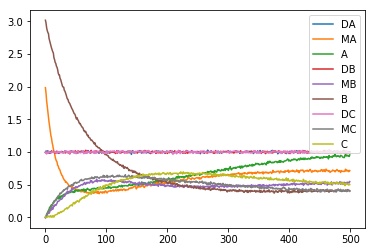

test


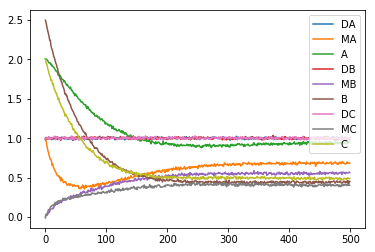

In [7]:
def plot_and_persist_lma_traj(t):
    plt.plot(t.counts[:, 0], label=species_names[0])
    plt.plot(t.counts[:, 1], label=species_names[1])
    plt.plot(t.counts[:, 2], label=species_names[2])
    plt.plot(t.counts[:, 3], label=species_names[3])
    plt.plot(t.counts[:, 4], label=species_names[4])
    plt.plot(t.counts[:, 5], label=species_names[5])
    plt.plot(t.counts[:, 6], label=species_names[6])
    plt.plot(t.counts[:, 7], label=species_names[7])
    plt.plot(t.counts[:, 8], label=species_names[8])
    plt.legend(loc="best")
    plt.show()
    t.persist()

print("train")
t = analysis.generate_or_load_traj_lma(train_n, target_time, noise_variance=noise_variance)
plot_and_persist_lma_traj(t)
print("test")
t = analysis.generate_or_load_traj_lma(test_n, target_time, noise_variance=noise_variance)
plot_and_persist_lma_traj(t)

In [8]:
for t in traj_n_s:
    traj = analysis.get_traj(t)
    traj.persist()

In [8]:
if False:
    analysis.calculate_lma_fd_derivative(train_n, target_time)
    analysis.calculate_lma_fd_derivative(test_n, target_time)
if False:
    analysis.ca

Dont have derivative (got 0 but need 9)
Dont have derivative (got 0 but need 9)


In [9]:
# species DA  MA  A  DB  MB  B  DC  MC  C
# ids     0   1   2  3   4   5  6   7   8
analysis.obtain_lma_trajectories(
    target_time,
    noise_variance=noise_variance,
    species=[0, 3, 6],
    # alphas=np.linspace(0.0005, 0.01, num=8),
    alphas=np.array([0.001, 0.0011]),
    verbose=True, 
    atol=5e-5,
    maxit=50, 
    search_depth=1, 
    selection=[test_n, train_n],
    #subdivisions=3,
    override=False,
)

obtaining derivative for species [0 3 6]
Dont have derivative (got 0 but need 9)
got 500 counts (and 500 corresp. time steps), dt= 0.006


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

found alpha=0.0011 to be best with a difference of 7.627402466474007e-06 between mse and variance
got ix 1


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

MSE = 9.2372597533526e-05 noise variance = 0.0001


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

found alpha=0.0011 to be best with a difference of 8.912306033047214e-05 between mse and variance
got ix 1


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

MSE = 0.00018912306033047214 noise variance = 0.0001


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

found alpha=0.0011 to be best with a difference of 1.90767716752007e-05 between mse and variance
got ix 1


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

MSE = 0.0001190767716752007 noise variance = 0.0001
obtaining derivative for species [0 3 6]
Dont have derivative (got 0 but need 9)
got 500 counts (and 500 corresp. time steps), dt= 0.006


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

found alpha=0.0011 to be best with a difference of 0.0004034902989054182 between mse and variance
got ix 1


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

MSE = 0.0005034902989054182 noise variance = 0.0001


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

found alpha=0.0011 to be best with a difference of 4.936886568117771e-05 between mse and variance
got ix 1


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

MSE = 0.0001493688656811777 noise variance = 0.0001


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

found alpha=0.0011 to be best with a difference of 5.6835659072476736e-05 between mse and variance
got ix 1


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

MSE = 0.00015683565907247674 noise variance = 0.0001


In [26]:
# species DA  MA  A  DB  MB  B  DC  MC  C
# ids     0   1   2  3   4   5  6   7   8
analysis.obtain_lma_trajectories(
    target_time,
    noise_variance=noise_variance,
    species=[1, 2, 4, 5, 7, 8],
    # alphas=np.linspace(0.0005, 0.01, num=8),
    alphas=np.array([0.0005, 0.0011]),
    verbose=True, 
    atol=5e-5,
    maxit=50, 
    search_depth=1, 
    selection=[test_n, train_n],
    #subdivisions=3,
    override=True,
)

obtaining derivative for species [1 2 4 5 7 8]
got 500 counts (and 500 corresp. time steps), dt= 0.006


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

found alpha=0.0005 to be best with a difference of 0.0029515575868315352 between mse and variance
got ix 0


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

MSE = 0.003051557586831535 noise variance = 0.0001


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

found alpha=0.0005 to be best with a difference of 0.0002570480390028426 between mse and variance
got ix 0


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

MSE = 0.00035704803900284257 noise variance = 0.0001


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

found alpha=0.0005 to be best with a difference of 0.00018340406584892323 between mse and variance
got ix 0


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

MSE = 0.0002834040658489232 noise variance = 0.0001


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

found alpha=0.0005 to be best with a difference of 0.0001792220062356758 between mse and variance
got ix 0


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

MSE = 0.0002792220062356758 noise variance = 0.0001


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

found alpha=0.0005 to be best with a difference of 7.034866856815257e-05 between mse and variance
got ix 0


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

MSE = 0.00017034866856815257 noise variance = 0.0001


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

found alpha=0.0005 to be best with a difference of 0.00014925356575401781 between mse and variance
got ix 0


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

MSE = 0.0002492535657540178 noise variance = 0.0001
obtaining derivative for species [1 2 4 5 7 8]
got 500 counts (and 500 corresp. time steps), dt= 0.006


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

found alpha=0.0005 to be best with a difference of 0.00036368812098252996 between mse and variance
got ix 0


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

MSE = 0.00046368812098252995 noise variance = 0.0001


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

found alpha=0.0005 to be best with a difference of 2.110304180778036e-05 between mse and variance
got ix 0


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

MSE = 0.00012110304180778036 noise variance = 0.0001


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

found alpha=0.0005 to be best with a difference of 0.00020108005975375166 between mse and variance
got ix 0


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

MSE = 0.00030108005975375165 noise variance = 0.0001


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

found alpha=0.0005 to be best with a difference of 0.0005420601645729042 between mse and variance
got ix 0


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

MSE = 0.0006420601645729042 noise variance = 0.0001


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

found alpha=0.0005 to be best with a difference of 0.00014901196952230185 between mse and variance
got ix 0


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

MSE = 0.00024901196952230184 noise variance = 0.0001


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

found alpha=0.0005 to be best with a difference of 0.0002928343104251878 between mse and variance
got ix 0


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

MSE = 0.0003928343104251878 noise variance = 0.0001


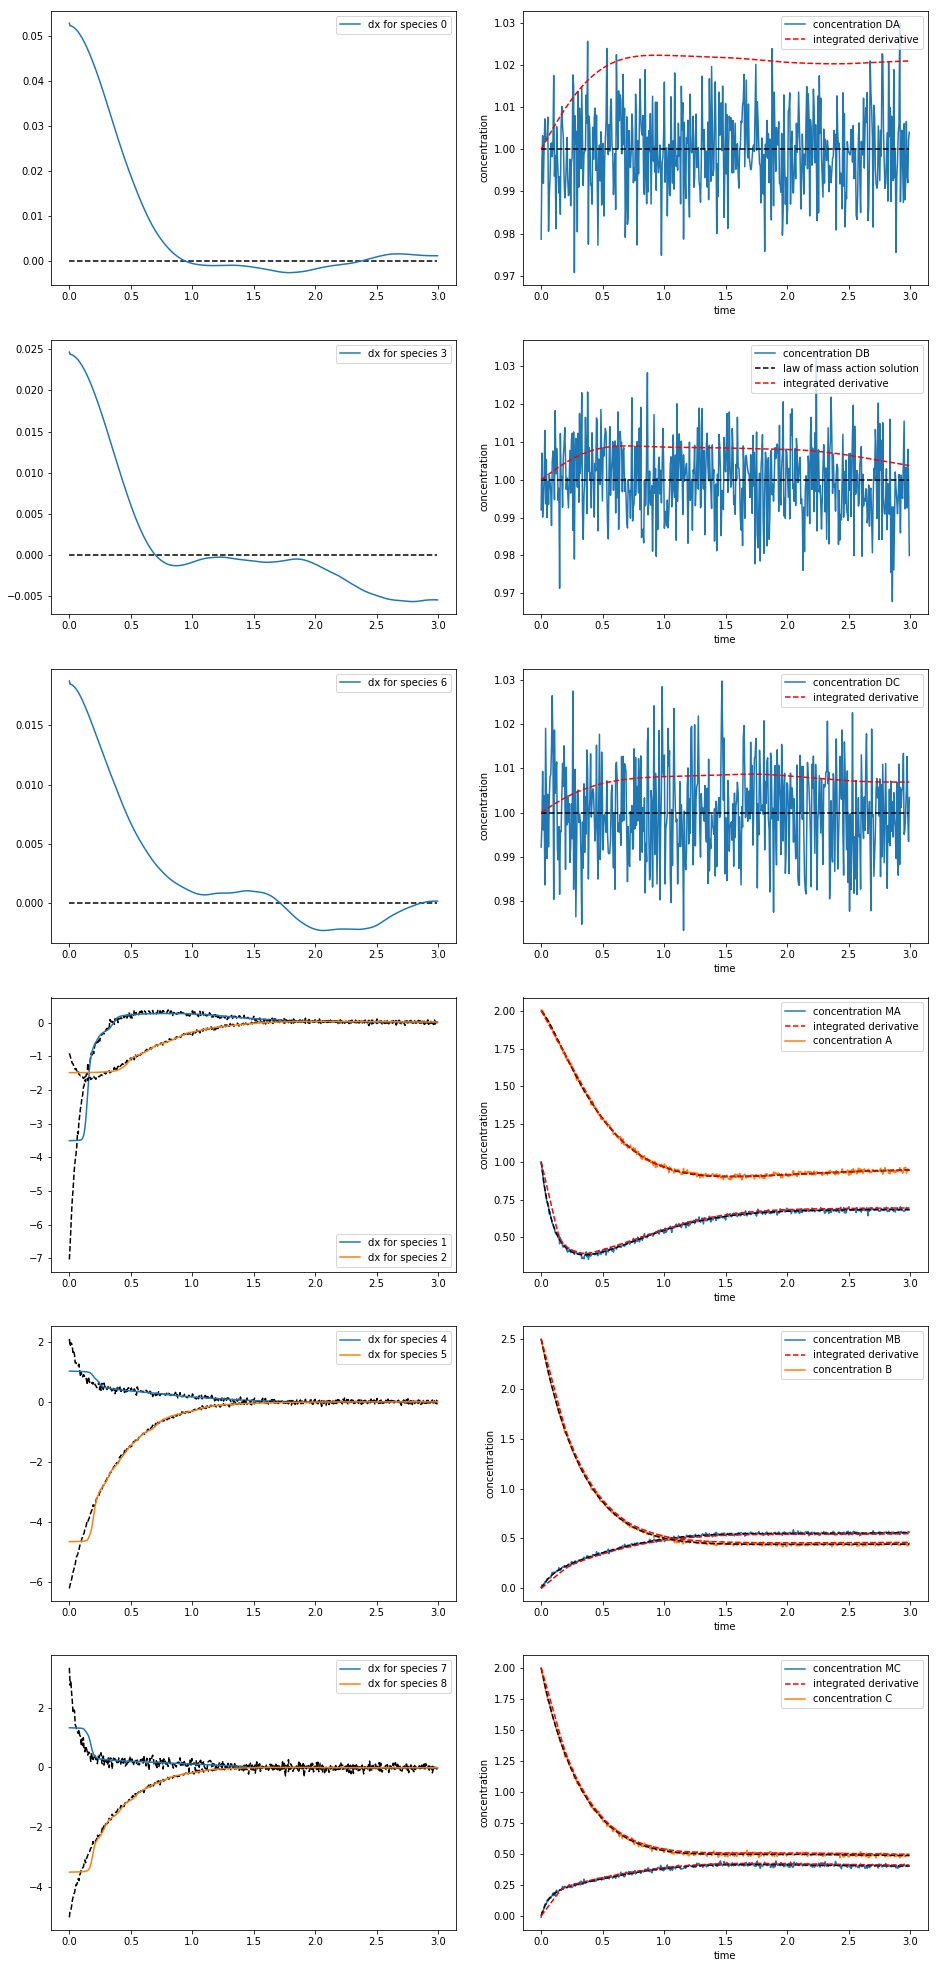

In [27]:
traj_number=test_n
pfs = [
    lambda t=traj_number: analysis.plot_derivatives(t, species=[0]),
    lambda t=traj_number: analysis.plot_concentration_curves(t, species=[0]),
    lambda t=traj_number: analysis.plot_derivatives(t, species=[3]),
    lambda t=traj_number: analysis.plot_concentration_curves(t, species=[3]),
    lambda t=traj_number: analysis.plot_derivatives(t, species=[6]),
    lambda t=traj_number: analysis.plot_concentration_curves(t, species=[6]),
    lambda t=traj_number: analysis.plot_derivatives(t, species=[1, 2]),
    lambda t=traj_number: analysis.plot_concentration_curves(t, species=[1, 2]),
    lambda t=traj_number: analysis.plot_derivatives(t, species=[4, 5]),
    lambda t=traj_number: analysis.plot_concentration_curves(t, species=[4, 5]),
    lambda t=traj_number: analysis.plot_derivatives(t, species=[7, 8]),
    lambda t=traj_number: analysis.plot_concentration_curves(t, species=[7, 8])
]
plot_overview(pfs, n_cols=2, n_rows=6, size_factor=1.3)
plt.show()

train_n 1 test_n 2
['three_species_traj_2_2.npz']


IntProgress(value=0, max=63)

params: alpha=1e-05, l1=0.0 with corresponding score 0.1668629210217855
train_n 1
optimization problem did exit successfully (alpha=1e-05, lambda=0.0)!
status 0: Optimization terminated successfully.
89 / 30000 iterations


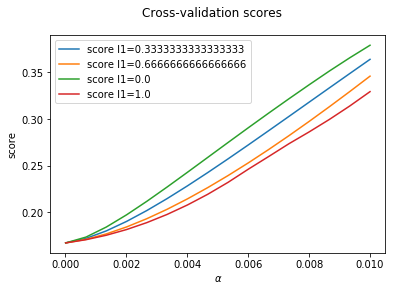

In [29]:
est_rates, cv_res = ana.do_the_cv(
    analysis,
    train_n=train_n,
    test_n=test_n,
    #alphas=np.linspace(0.00001,0.0004,num=32), # for no-noise scenario
    alphas=np.linspace(0.00001, 0.01, num=16),
    #alphas=np.array([0.000000001,0.0000000011]),
    l1_ratios=np.linspace(0., 1., num=4),
    recompute=True
)
ana.plot_cv_results(cv_res, mainscore=0, best_params_ix_l1=None)

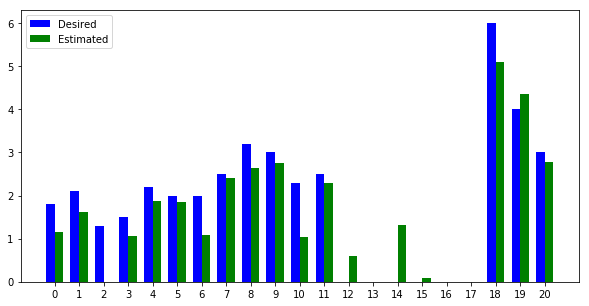

In [30]:
ana.plot_rates_bar(desired_rates, est_rates)

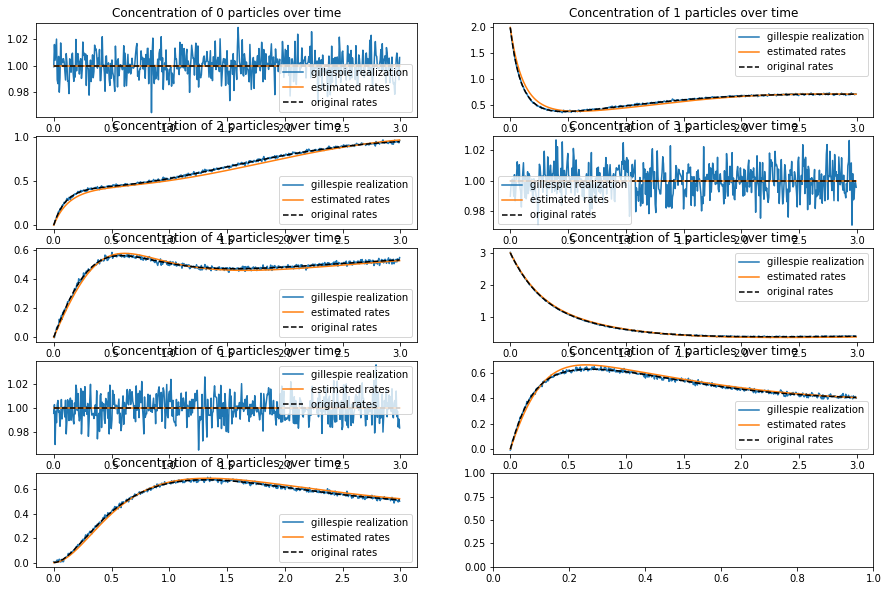

In [31]:
analysis.plot_results(train_n, est_rates)

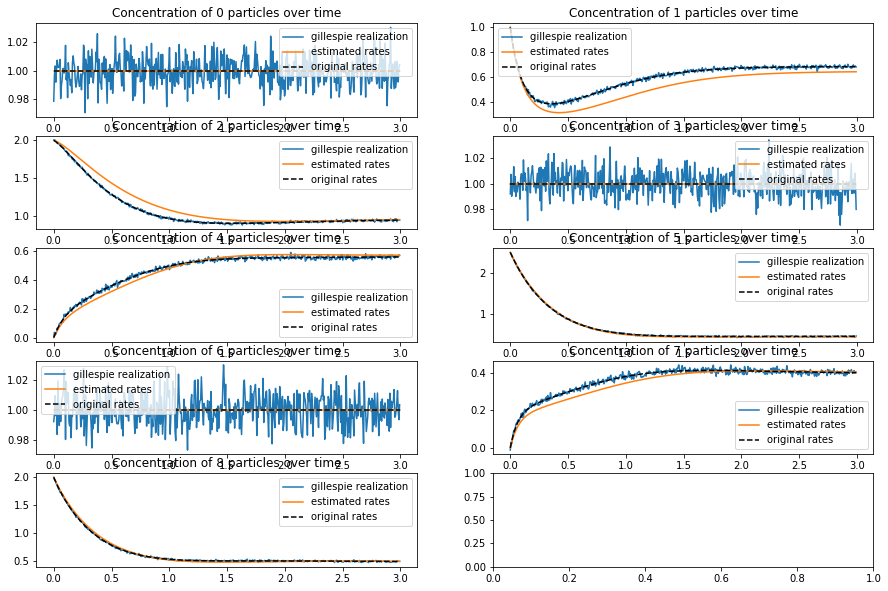

In [32]:
analysis.plot_results(test_n, est_rates)

# TODOs
- use estimated derivatives: does not work so well, I suspect the leveling off at the boundaries is a problem, since this is the only thing that differs from the analytic derivative, which yielded the desired result in the actual-rate estimation.
- more noise
- more basis functions